<center>
    <font size=7>
        Uber
    </font>
    <br>
    <br>
    <font size=4>
        Predict with Time Series
    </font>
</center>

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#Create-Time-Serie" data-toc-modified-id="Create-Time-Serie-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create Time Serie</a></span></li><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#Dickey–Fuller-test" data-toc-modified-id="Dickey–Fuller-test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dickey–Fuller test</a></span></li><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#ARIMA" data-toc-modified-id="ARIMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="http://localhost:8888/notebooks/Uber/Uber.ipynb#Prediction" data-toc-modified-id="Prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

# Libraries

In [14]:
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.tsatools import detrend
from statsmodels.api import OLS
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import datetime
import warnings
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (14,8)
pylab.style.use('seaborn-darkgrid')

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
df = pd.read_csv("uber.csv")[["Pickup_date"]]
df.head()

,Pickup_date
0,2015-05-17 09:47:00
1,2015-05-17 09:47:00
2,2015-05-17 09:47:00
3,2015-05-17 09:47:00
4,2015-05-17 09:47:00


# Create Time Serie

In [3]:
df["Timestamp"] = pd.to_datetime(df["Pickup_date"], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_cleaned = df.set_index(['Timestamp'])
del df_cleaned['Pickup_date']
df_cleaned["Picked"] = 1
df_uber = df_cleaned.resample('H').sum()
df_uber.head()

,Picked
Timestamp,
2015-01-01 00:00:00,6465
2015-01-01 01:00:00,6001
2015-01-01 02:00:00,7171
2015-01-01 03:00:00,5874
2015-01-01 04:00:00,3529


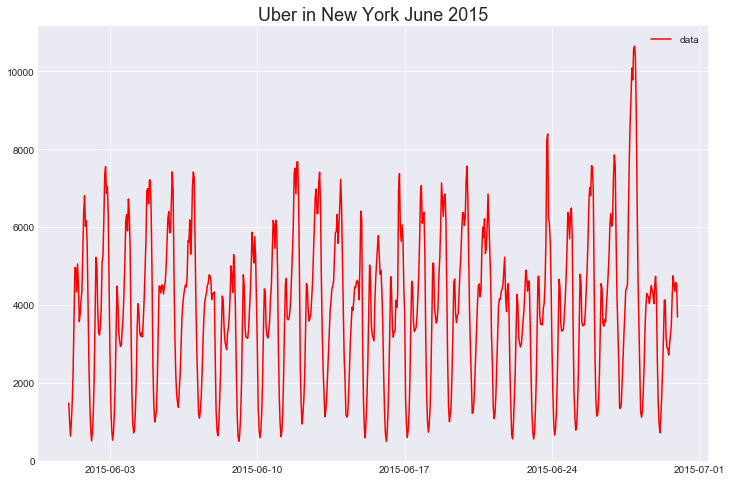

In [4]:
from datetime import datetime
start = datetime(2015, 6, 1)
end = datetime(2015, 6, 30)
df_uber_bordered = df_uber[(df_uber.index > start) & (df_uber.index < end)].copy()

plt.figure(figsize=(12, 8))
plt.plot(df_uber_bordered.index, df_uber_bordered.Picked, c="r", label="data")
plt.title("Uber in New York June 2015", fontsize=18)
plt.legend(loc=1, numpoints=1)
plt.show()

# Dickey–Fuller test

In [6]:
adfuller(series)

(-3.1535219632080063,
 0.022837625400301646,
 20,
 674,
 {'1%': -3.4400894360545475,
  '10%': -2.5690586760471605,
  '5%': -2.865837730028723},
 10165.457945532946)

2eme valeur c'est la p-value plus grande que critical values pour tous les taux 1%, 10%... donc pas suffisamment faible pour rejetter H0  
DONC ARIMA

# ARIMA

In [11]:
myrange = range(5)
series = df_uber_bordered.Picked
X = series.values

cpt = 0
for d in range(1):
    for p in myrange:
        for q in myrange:
            try:
                model = ARIMA(X, order=(p,d,q)).fit(method='mle', trend='nc')
                tmp_aic = model.aic
                if cpt == 0:
                    best_aic = tmp_aic
                    cpt += 1
                if tmp_aic <= best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
            except: continue
#####

print("Best parameters", best_order)
best_model = ARIMA(X, order=best_order).fit(method='mle', trend='nc')
best_model.summary()

Meilleurs paramètres (4, 0, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  695
Model:                     ARMA(4, 2)   Log Likelihood               -5360.638
Method:                           mle   S.D. of innovations            538.066
Date:                Tue, 13 Feb 2018   AIC                          10735.276
Time:                        23:06:20   BIC                          10767.083
Sample:                             0   HQIC                         10747.575
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        2.1660   1.88e-05   1.15e+05      0.000       2.166       2.166
ar.L2.y       -1.3212   1.86e-05   -7.1e+04      0.000      -1.321      -1.321
ar.L3.y       -0.0539        nan        nan        nan         nan         nan
ar.L4.y        0.2090        nan        nan        nan         nan         nan
ma.L1.y       -0.4728      0.032    -14.840      0.000      -0.535      -0.410
ma.L2.y       -0.5245      0.032    -16.462      0.000      -0.587      -0.462
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           -0.0000j            1.0000           -0.0000
AR.2            1.1630           -0.4543j            1.2486           -0.0593
AR.3            1.1630           +0.4543j            1.2486            0.0593
AR.4           -3.0683           -0.0000j            3.0683           -0.5000
MA.1            1.0018           +0.0000j            1.0018            0.0000
MA.2           -1.9032           +0.0000j            1.9032            0.5000
-----------------------------------------------------------------------------
"""

# Prediction

Dataset 620, Validation 75


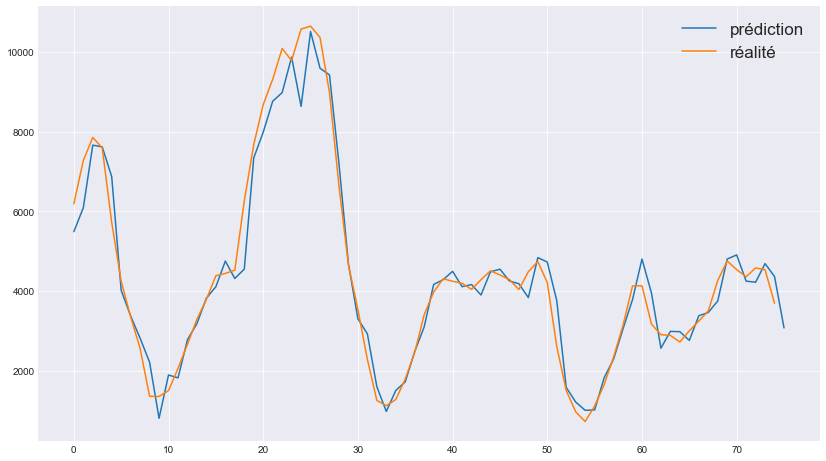

In [13]:
series = df_uber_bordered.Picked
split_point = len(series) - 75
train, test = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

start_index = len(train)
end_index = start_index + len(test) 
forecast = model.predict(start=start_index, end=end_index)

plt.figure(figsize=(14,8))
plt.plot(forecast)
plt.plot(test.values)
plt.legend(["prediction", "reality"], prop={'size': 17})
plt.show()

It looks really good !! <br>
Thank you ! The notebook to apprehend Time Series is now over !